In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import soundfile as sf
import matplotlib.pyplot as plt

from tqdm import tqdm
from pathlib import Path
from IPython.display import Audio
from natsort import natsorted
from scipy.signal import stft
from librosa import resample

from joblib import Parallel, delayed
from datetime import datetime, timedelta


import alphaMusic.evaluation as evl
import alphaMusic.utils.fls_utils as fls
import alphaMusic.utils.acu_utils as acu
import alphaMusic.utils.geo_utils as geo
import alphaMusic.utils.mat_utils as mat

from alphaMusic.dataloaders import LocataDataset
from pyroomacoustics.datasets.locata import LOCATA, _find_ts


from IPython.display import Audio

In [8]:
path_to_locata = Path('..','data','Locata','dev')
print(path_to_locata.exists())

tasks = [2]
arrays = ['benchmark2']

path_to_tmp = Path('..','.cache',f'locata_db_task_{tasks[0]}_array_{arrays[0]}.pkl')

dB = LOCATA(path_to_locata, verbose=True, tasks=tasks, arrays=arrays)
# if not path_to_tmp.exists():
#     dB = LOCATA(path_to_locata, verbose=True, tasks=tasks, arrays=arrays)
#     fls.save_to_pkl(path_to_tmp, dB)
#     print(f'Save to {path_to_tmp}')
# else:
#     print(f'Load from {path_to_tmp}')
#     dB = fls.load_from_pkl(path_to_tmp)

True
../data/Locata/dev/task2/recording1/benchmark2


/home/dicarlo_d/Documents/Code/alphaMUSIC/pyroomacoustics/pyroomacoustics/datasets/locata.py:153: UserWarning: The eval folder is missing. Please check the structure of the dataset directory.
  warnings.warn('The ''eval'' folder is missing. Please check the structure of the dataset directory.')


../data/Locata/dev/task2/recording3/benchmark2


In [4]:
# results = pd.DataFrame()

# nfft = 1024
# minF = 500
# maxF = 4000
# n_frames = 100

# for r, recordings in enumerate(dB.recordings):
    
#     data = recordings.data
#     fs = recordings.fs
#     timestamps = recordings.ts
    
#     pos = []
    
#     # STFT
#     stft_signals = stft(data.T, fs=fs, nperseg=nfft, noverlap=0.5)[2]
    
#     tot_timestamps = len(timestamps)
#     ini_frame = nfft*n_frames//2
#     end_frame = tot_timestamps - nfft*(n_frames//2+1)
    
#     for t, ts in enumerate(tqdm(timestamps)): # for each timestamp (1/Fs)
        
#         if t % (nfft) == 0 and t > ini_frame and t <  end_frame:
            
#             n = t // nfft
            
#             mic_pos = recordings.get_array(ts['ts'])
#             doa = recordings.get_doa(ts['ts'])
#             src_pos = recordings.get_src_pos(ts['ts'])
            
#             curr_doas = []
#             curr_vads = []
            
#             for s in src_pos.keys():
                
#                 vad = recordings.sources[s]['vad'][t]
#                 azimuth = np.rad2deg(doa[s]['azimuth'])
                
#                 curr_doas.append(azimuth)
#                 curr_vads.append(vad)
            
#             results.at[n, 'DOAs'] = azimuth + 90
#             results.at[n, 'VAD'] = curr_vads[0]
#             n_srcs = len(curr_doas)

#             from pyroomacoustics import doa
#             from alphaMusic.alphaMUSIC import aMUSIC

#             kwargs = {'L': mic_pos,
#                       'fs': fs, 
#                       'nfft': nfft,
#                       'azimuth': np.deg2rad(np.arange(360,step=1)),
#                       'num_src': n_srcs,

#             }
#             algorithms = {
#                 'MUSIC': doa.music.MUSIC(**kwargs),
#                 'aMUSIC_est' : aMUSIC(**kwargs,alpha=3,frequency_normalization=False),
#                 'aMUSIC_fix' : aMUSIC(**kwargs,alpha=1.5,frequency_normalization=False),
#                 'NormMUSIC': doa.normmusic.NormMUSIC(**kwargs),
#                 'aNormMUSIC_est' : aMUSIC(**kwargs,alpha=3,frequency_normalization=True),
#                 'aNormMUSIC_fix' : aMUSIC(**kwargs,alpha=1.5,frequency_normalization=True),
#                 'SRP_PHAT' : doa.srp.SRP(**kwargs),
#             }

#             # OUR MUSIC
#             for algo_name, algo in algorithms.items():

#                 algo.locate_sources(stft_signals[:,:,n-n_frames//2:n+n_frames//2+1], 
#                                     num_src=n_srcs, 
#                                     freq_range=[minF, maxF], 
#                                     mpd=10)
                
#                 doa_est = np.rad2deg(algo.azimuth_recon)[0]
#                 results.at[n, algo_name] = doa_est
#     break      
# #         fig = plt.figure()
# #         plt.suptitle(np.rad2deg(doa[s]['azimuth']))
# #         ax = plt.subplot(121, projection='3d')
# #         ax.scatter(mic_pos[0,:], mic_pos[1,:], mic_pos[2,:], marker='o')
# #         ax.scatter(src_pos[s][0], src_pos[s][1], src_pos[s][2], marker='x')
# #         ax = plt.subplot(122)
# #         ax.scatter(mic_pos[0,:], mic_pos[1,:], marker='o')
# #         ax.scatter(s|rc_pos[s][0], src_pos[s][1], marker='x')

# #         plt.tight_layout(pad=0.5)
# #         plt.show()

In [5]:
# plt.figure(figsize=(20,10))
# plt.plot(360*results['VAD'], label='vad')
# plt.plot(results['DOAs'], label='groundtruth')
# plt.plot(results['MUSIC'], label='MUSIC')
# plt.plot(results['NormMUSIC'], label='NormMUSIC')
# plt.plot(results['SRP_PHAT'], label='SRP')
# plt.plot(results['aMUSIC_est'], label='aMUSIC')
# plt.legend()

In [9]:
results = pd.DataFrame()

Fs = 16000
nfft = 1024
minF = 500
maxF = 4000
n_frames = 10

for r, recordings in enumerate(dB.recordings):
    
    print(f'Recording #{r}')
    if r in [0]:
        continue
    
    data = recordings.data
    fs = recordings.fs
    timestamps = recordings.ts
    
    name_srcs = list(recordings.sources.keys())
    num_srcs = len(name_srcs)
    print(num_srcs)
    
    # Resample VAD
    vads = {}
    for src in name_srcs:
        v = recordings.sources[src]['vad']
        vads[src] = v
        
        
    # Resample 48kHz -> 16kHz
    data = resample(data.T, orig_sr=fs, target_sr=Fs)
    
    # STFT
    freqs, times, stft_signals = stft(data, fs=Fs, nperseg=nfft, noverlap=0.5)
    
    M, F, T = stft_signals.shape
    
    # iterate over frames
    starting_timestamp = recordings.get_ts(0)
    for t in tqdm(range(T)):
        
        ts = times[t]
        ts = starting_timestamp + timedelta(seconds=ts)
        
        mic_pos = recordings.get_array(ts)
        doa_dict = recordings.get_doa(ts)

        doas = {}
        doas_arr = []
        
        num_srcs = 0
        for s, src in enumerate(doa_dict.keys()):
                
            azimuth = np.rad2deg(doa_dict[src]['azimuth'])

            doas[src] = azimuth
            doas_arr.append(azimuth)
        
            results.at[t, f'DOA_{s}'] = doas[src]
            
            idx = _find_ts(timestamps, ts)
            results.at[t, f'VAD_{s}'] = vads[src][idx]
            num_srcs += vads[src][idx]
        
        num_srcs = int(num_srcs)
        results.at[t, 'J'] = num_srcs
        
        if num_srcs == 0:
            continue
            
        if t > n_frames//2 and t < T - (n_frames//2+1):
                        
            from pyroomacoustics import doa
            from alphaMusic.alphaMUSIC import aMUSIC

            kwargs = {'L': mic_pos,
                      'fs': Fs, 
                      'nfft': nfft,
                      'azimuth': np.deg2rad(np.arange(360,step=1)),
                      'num_src': num_srcs,
            }

            algorithms = {
                'MUSIC': doa.music.MUSIC(**kwargs),
                'aMUSIC_est' : aMUSIC(**kwargs,alpha=3,frequency_normalization=False),
#                 'aMUSIC_fix' : aMUSIC(**kwargs,alpha=1.5,frequency_normalization=False),
                'NormMUSIC': doa.normmusic.NormMUSIC(**kwargs),
                'aNormMUSIC_est' : aMUSIC(**kwargs,alpha=3,frequency_normalization=True),
#                 'aNormMUSIC_fix' : aMUSIC(**kwargs,alpha=1.5,frequency_normalization=True),
                'SRP_PHAT' : doa.srp.SRP(**kwargs),
            }

            for algo_name, algo in algorithms.items():

                algo.locate_sources(stft_signals[:,:,t-n_frames//2:t+n_frames//2+1], 
                                    num_src=num_srcs, 
                                    freq_range=[minF, maxF], 
                                    mpd=1)

                doas_est = np.rad2deg(algo.azimuth_recon).tolist()
                
                doas_est_back = []
                for doa in doas_est:
                    if doa > 180:
                        doa = 360 - doa
                    doas_est_back.append(doa)
                        
                doas_est = sorted(doas_est_back)
#                 doas_est = sorted(doas_est)
                
                # append NaN if some sources are not retrieved
                n_missing = num_srcs - len(doas_est)
                for i in range(n_missing):
                    doas_est.append(0)
                    
                assert len(doas_est) == num_srcs

                # find best combination of DOAs
#                 if num_srcs > 1:
#                     doas_est = evl.best_match_sorted(doas_est, doas_arr)
                
                for d, doa in enumerate(doas_est):
                    results.at[t, f'{algo_name}_{d}'] = doa

Recording #0
Recording #1
3


100%|███████████████████████████████████████████████████████████████████████████████████| 99/99 [01:05<00:00,  1.50it/s]


In [6]:
# results = results.dropna()
results.head(40)

,DOA_0,VAD_0,DOA_1,VAD_1,DOA_2,VAD_2,J,MUSIC_0,aMUSIC_est_0,NormMUSIC_0,...,MUSIC_1,aMUSIC_est_1,NormMUSIC_1,aNormMUSIC_est_1,SRP_PHAT_1,MUSIC_2,aMUSIC_est_2,NormMUSIC_2,aNormMUSIC_est_2,SRP_PHAT_2
0,61.935932,0.0,43.686636,0.0,101.449085,0.0,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,61.935932,0.0,43.686636,0.0,101.449085,0.0,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,61.935932,0.0,43.686636,0.0,101.449085,0.0,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,61.935932,0.0,43.686636,0.0,101.449085,0.0,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,61.935932,0.0,43.686636,0.0,101.449085,0.0,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,61.935932,0.0,43.686636,0.0,101.449085,0.0,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,61.935932,0.0,43.686636,0.0,101.449085,0.0,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,61.935932,0.0,43.686636,0.0,101.449085,0.0,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,61.935932,0.0,43.686636,0.0,101.449085,0.0,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,61.935932,0.0,43.686636,0.0,101.449085,0.0,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


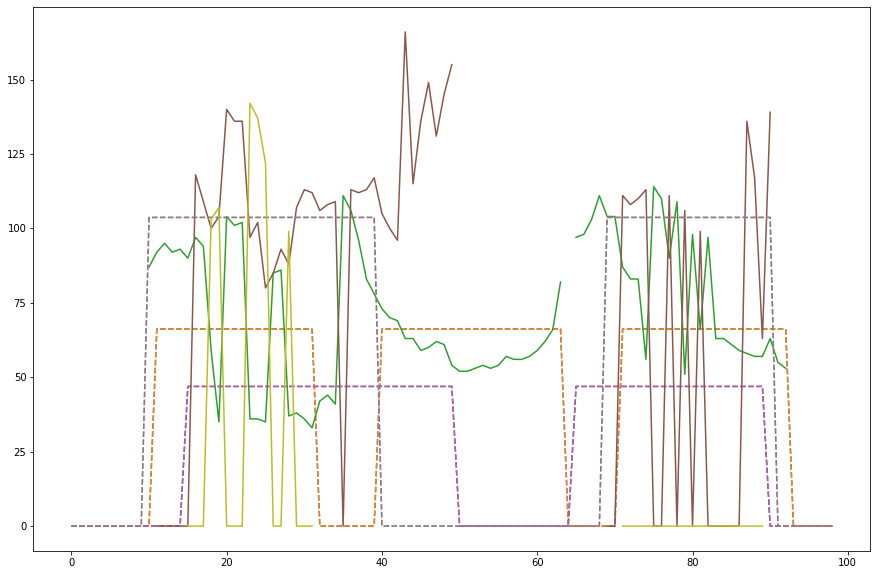

In [15]:
plt.figure(figsize=(15,10))
for src in [0, 1, 2]:
    plt.plot(results[f'DOA_{src}']*results[f'VAD_{src}'], '--', label='VAE')
    plt.plot(results[f'DOA_{src}']*results[f'VAD_{src}'], '--', label='VAE')

    for algo in ['aMUSIC_est']:
        plt.plot(results[f'{algo}_{src}'])

In [ ]:
# fls.save_to_pkl(Path('locata_db_task_{tasks[0]}_array_{arrays[0]}_results.pkl'), results)

In [ ]:
MAE, MEDAE = {}, {}

def calc_ae(a,b):
    x = np.abs(a-b)
    return np.min(np.array((x, np.abs(360-x))), axis=0)

for algo_name in algorithms.keys():
    
    src = 0
        
    curr_df = results.loc[(results[f'VAD_{src}'] == 1)]
    curr_df = curr_df.dropna()
    
    ae = calc_ae(curr_df.loc[:,[f"DOA_{src}"]].to_numpy(), 
                 curr_df.loc[:,[f"{algo_name}_{src}"]].to_numpy())
    MAE[algo_name] = np.mean(ae)
    MEDAE[algo_name] = np.median(ae)
    
# err = calc_ae(df.loc[:,["DOA"]].to_numpy(), df.loc[:,["DOAest"]].to_numpy()).squeeze()
# df['Err'] = err
print("Algo \t\t MAE \t MEDAE")
for algo_name in algorithms.keys():
    print(f"{algo_name}\t {MAE[algo_name]:5.2f} \t {MEDAE[algo_name]:5.2f}")